In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def mavg_strat(ts, short_mavg, long_mavg, tc):
    
    '''
    
    ret_ts: returns time series
    short_mavg: short moving avg parameter
    long_mavg: long moving avg parameter
    tc: transaction costs in decimal e.g. 1 = 100%, 0.5=50%
    
    '''
    df = ts.to_frame('ret')
    df['cum_ret'] = (df['ret']+1).cumprod() -1
    df['short_mavg_ret'] = df['cum_ret'].rolling(short_mavg).mean()
    df['long_mavg_ret'] = df['cum_ret'].rolling(long_mavg).mean()
    
    df = df[~df.long_mavg_ret.isna()]
    
    df.loc[:,"crossed"] = 0
    df.loc[df.short_mavg_ret>df.long_mavg_ret, "crossed"] = 1

    df['signal'] = df.crossed.diff()

    df['tc'] = df['signal'].abs() * tc 
    df['tc_cum'] = df['tc'].add(1).cumprod() -1
    
    df['num_trans'] = df['signal'].abs().sum()

    df['strat_ret_no_tc'] = df['ret']*df['crossed'] 
    df['cum_strat_ret_no_tc'] = df['strat_ret_no_tc'].add(1).cumprod() - 1

    df['cum_bmk_ret'] = df['ret'].add(1).cumprod() - 1
    
    df['strat_ret'] = df['ret']*df['crossed'] - df['tc']
    df['cum_strat_ret'] = df['strat_ret'].add(1).cumprod() - 1
    
    
    df['active_ret'] = df['cum_strat_ret'] - df['cum_ret']
    
    return df

## Loading data

In [3]:
df = pd.read_csv("./data/XBTUSD_DAILY.csv")

## From prices to daily returns and cumulative returns

In [4]:
df['ret'] = df['close']/df['close'].shift(1) -1
df['cum_ret'] = (df['ret']+1).cumprod() 

In [5]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [7]:
ret_ts = df['ret'].copy()

## Parameters:

- Transaction costs = 3%
- Short moving avg = 1 day
- Long moving avg = 8 days

In [37]:
X_test =  ret_ts.loc['2021-01-01':].copy()
y_test = mavg_strat(X_test, short_mavg=1, long_mavg=14, tc=0.03)

In [38]:
signal = y_test.iloc[-1]['signal']
crossed = y_test.iloc[-1]['crossed']

# Model output

In [39]:
if signal == 1 and crossed ==1:
    print ("BUY!")
if signal == -1 and crossed == 0:
    print ("SELL")
if signal == 0 and crossed == 1:
    print ("HOLD LONG POSITION")
if signal == 0 and crossed == 0:
    print ("HOLD SHORT POSITION")


HOLD SHORT POSITION


### Visualisation

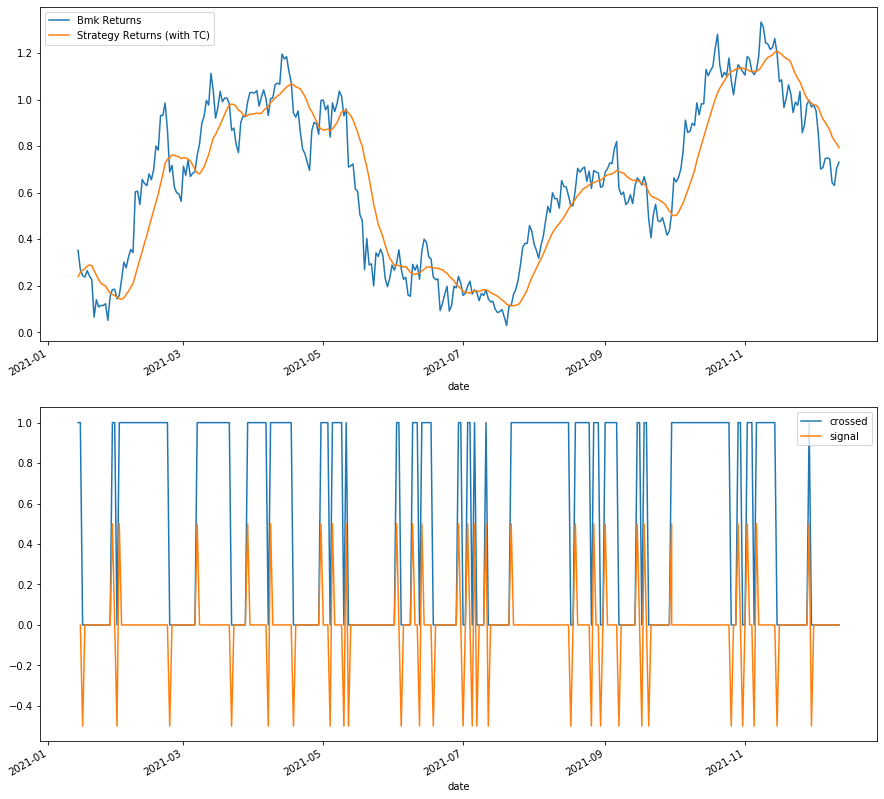

In [40]:
f,ax = plt.subplots(2,1,figsize=(15,15))

y_test['short_mavg_ret'].plot(ax=ax[0], label='Bmk Returns')
y_test['long_mavg_ret'].plot(ax=ax[0], label='Strategy Returns (with TC)')

y_test['crossed'].plot(ax=ax[1], label='crossed')
(y_test['signal']/2).plot(ax=ax[1], label='signal')

ax[0].legend()
ax[1].legend()

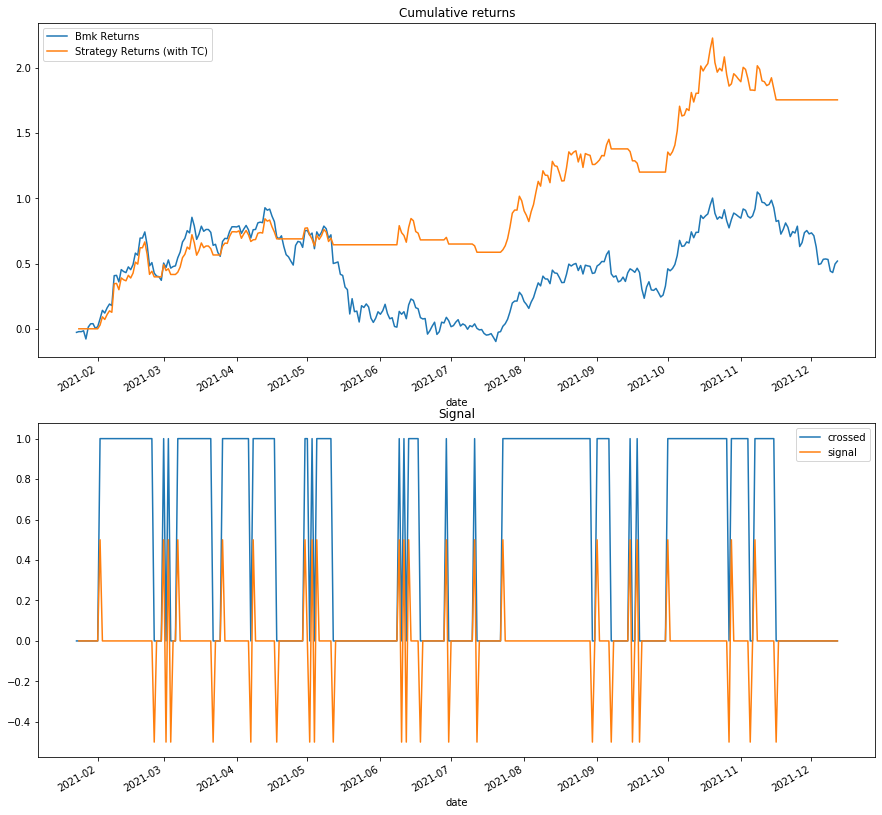

In [36]:
f,ax = plt.subplots(2,1,figsize=(15,15))

y_test['cum_bmk_ret'].plot(ax=ax[0], label='Bmk Returns')
y_test['cum_strat_ret'].plot(ax=ax[0], label='Strategy Returns (with TC)')
# y_test['cum_strat_ret_no_tc'].plot(ax=ax[0], label='Strategy Returns (no TC)')


y_test['crossed'].plot(ax=ax[1], label='crossed')
(y_test['signal']/2).plot(ax=ax[1], label='signal')

ax[0].legend()
ax[0].set_title("Cumulative returns")

ax[1].set_title("Signal")
ax[1].legend()